# Evaluate SCHOLAR results

In [397]:
import os, sys, scipy, json
from scipy import sparse
import codecs
import numpy as np
import pandas as pd
import file_handling as fh
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Select target variable

In [547]:
# gdp | cpi | u
target = "u"
# all_gb_texts | gdp_text,...
text_type = "all_gb_texts"

In [548]:
if sys.platform == "darwin":
    pass
else:
    input_dir = "/nfs/home/maxa/results/"+"mp_speeches"+'/'+text_type+"/"+target+"_target/"+"traindev/"    
    data_dir = "/nfs/home/maxa/data/mp_speeches/" 
print(input_dir)

/nfs/home/maxa/results/mp_speeches/all_gb_texts/u_target/traindev/


In [549]:
# load and merge timestamps - greenbook
df_gb = pd.read_csv(os.path.join(data_dir,"gb_dtm+data/REGALLTEXT_gb_dataset.csv"), index_col = 0)
gb_dates = []
for dd in df_gb.meet_date.values:
    gb_dates.append(dd[:-3])

In [550]:
# load and merge timestamps - speeches
df_sp = pd.read_csv(os.path.join(data_dir,"speeches_dtm+data/speeches_metadata_tfidf17.csv"), index_col = 0)
gb_dates_sp = []
for dd in df_sp.gb_date.values:
    gb_dates_sp.append(dd[:-3])

# Select model for evaluation

In [551]:
k = 10
bz = 25
run = "ep10000_run1" 
model = "k"+str(k)+"/bz"+str(bz)+"/"+run+"/"
model_path = input_dir + model
print(model)
print(model_path)

k10/bz25/ep10000_run1/
/nfs/home/maxa/results/mp_speeches/all_gb_texts/u_target/traindev/k10/bz25/ep10000_run1/


In [552]:
model_output = model_path + "eval/"
try:
    os.mkdir(model_output)
except:
    pass

In [553]:
model_output

'/nfs/home/maxa/results/mp_speeches/all_gb_texts/u_target/traindev/k10/bz25/ep10000_run1/eval/'

# Predictive R^2

In [554]:
pR_gb = pd.read_csv(os.path.join(model_path,"pR2.train_best_dev.csv"),index_col = 0)
pR_sp = pd.read_csv(os.path.join(model_path,"pR2.test_best_dev.csv"),index_col = 0)

In [555]:
print("pr2 in Greenbooks:", round(pR_gb.values[0][0],4))
print("pr2 in Speeches:", round(pR_sp.values[0][0],4))

pr2 in Greenbooks: 0.5643
pr2 in Speeches: 0.6527


# Topic regression chart

In [556]:
regcoefs = pd.read_csv(os.path.join(model_path,"regression_weights.best_dev.csv"), index_col  = 0)
topicdata =  pd.read_table(os.path.join(model_path,"topics_unweighted.best_dev.txt"), header = None)
topicdata.columns = ["topwords_all"]
topiccoefs = regcoefs[:k]
covarcoefs = regcoefs[k:]

In [557]:
n_topwords = 10
top_n = []
for topic in topicdata.topwords_all:
    top_n.append(" ".join(topic.split(" ")[:n_topwords]))
topicdata["topwords"] = top_n

In [558]:
topicdata["coefs"] = topiccoefs
topicdata.sort_values(by = "coefs", ascending = False)

,topwords_all,topwords,coefs
3,mbs functioning guarantee foreclosure spent st...,mbs functioning guarantee foreclosure spent st...,0.695608
4,trillion sovereign gaps emergency scenarios pa...,trillion sovereign gaps emergency scenarios pa...,0.657754
2,conventional implemented package legal sa dall...,conventional implemented package legal sa dall...,0.330053
5,functioning anchored tips headline homeowners ...,functioning anchored tips headline homeowners ...,0.060598
9,sa cooperation homeownership chart intermediar...,sa cooperation homeownership chart intermediar...,-0.046930
8,anchored tips accommodation headline drilling ...,anchored tips accommodation headline drilling ...,-0.127885
0,stabilization sheet chart posed highlight fina...,stabilization sheet chart posed highlight fina...,-0.273600
1,crossborder gaps highlight unconventional effe...,crossborder gaps highlight unconventional effe...,-0.381438
7,largescale deep highlight efficiency implement...,largescale deep highlight efficiency implement...,-0.395391
6,examine encouraging measurement deflation frac...,examine encouraging measurement deflation frac...,-0.427305


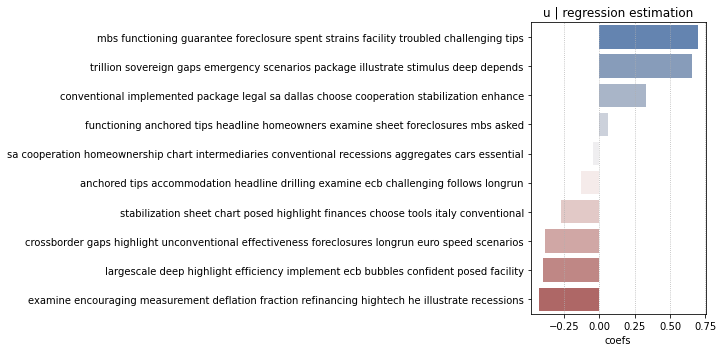

In [559]:
width = 10
height = 5
data = topicdata.sort_values(by = "coefs", ascending = False)
f, ax = plt.subplots(figsize=(width, height))
sns.barplot(x = data.coefs, y = data.topwords,  palette="vlag", orient = "h")
# Tweak the visual presentation
ax.xaxis.grid(True, linestyle=":")
ax.set(ylabel="")
#sns.despine(trim=True, left=True)
plt.title("{} | regression estimation".format(target))
plt.tight_layout()
plt.savefig(os.path.join(model_output, "{}_gb_topic_regression_chart.pdf".format(target)))

# Topics over time

In [560]:
theta_gb = pd.DataFrame(np.load(os.path.join(model_path,"theta.train_best_dev.npz"))["theta"])
theta_gb.index = gb_dates

In [561]:
topicdata.T

,0,1,2,3,4,5,6,7,8,9
topwords_all,stabilization sheet chart posed highlight fina...,crossborder gaps highlight unconventional effe...,conventional implemented package legal sa dall...,mbs functioning guarantee foreclosure spent st...,trillion sovereign gaps emergency scenarios pa...,functioning anchored tips headline homeowners ...,examine encouraging measurement deflation frac...,largescale deep highlight efficiency implement...,anchored tips accommodation headline drilling ...,sa cooperation homeownership chart intermediar...
topwords,stabilization sheet chart posed highlight fina...,crossborder gaps highlight unconventional effe...,conventional implemented package legal sa dall...,mbs functioning guarantee foreclosure spent st...,trillion sovereign gaps emergency scenarios pa...,functioning anchored tips headline homeowners ...,examine encouraging measurement deflation frac...,largescale deep highlight efficiency implement...,anchored tips accommodation headline drilling ...,sa cooperation homeownership chart intermediar...
coefs,-0.2736,-0.381438,0.330053,0.695608,0.657754,0.0605981,-0.427305,-0.395391,-0.127885,-0.0469303


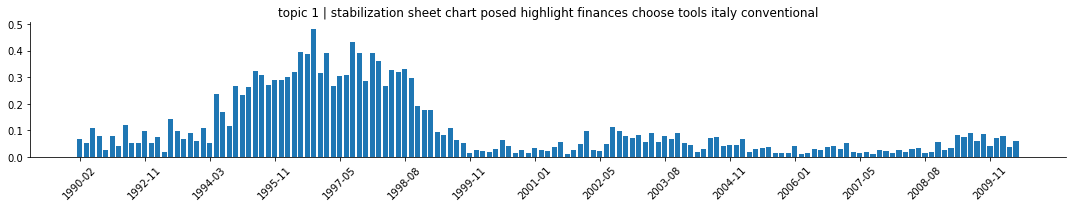

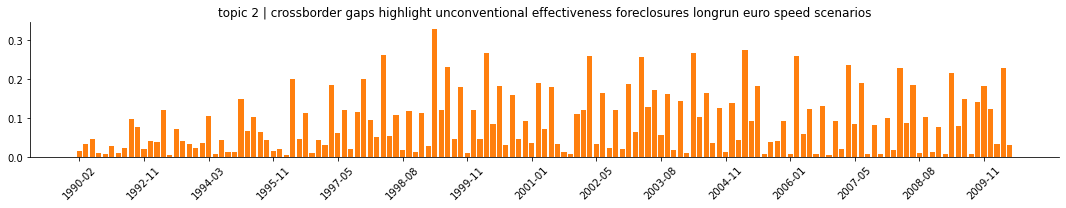

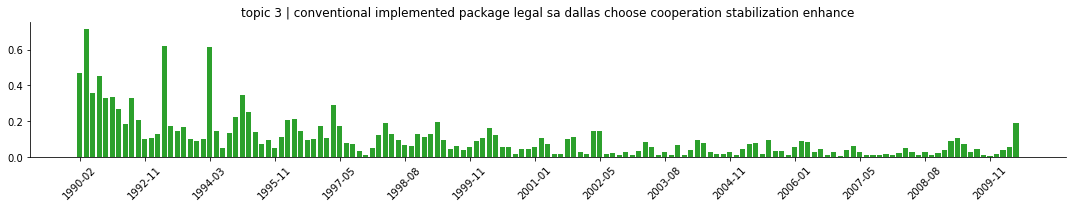

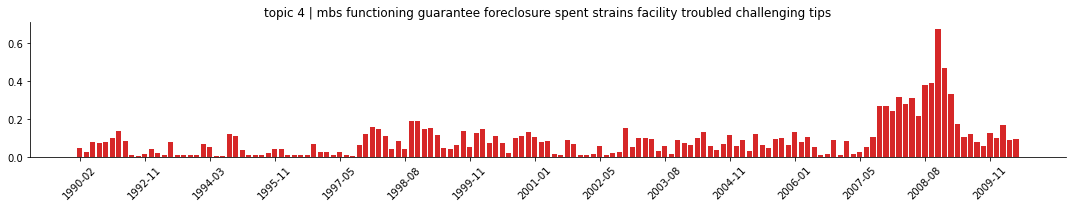

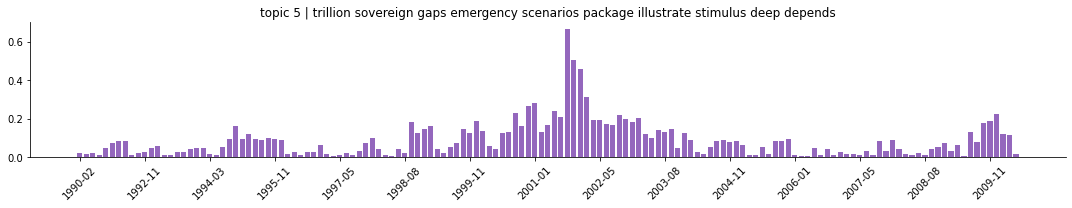

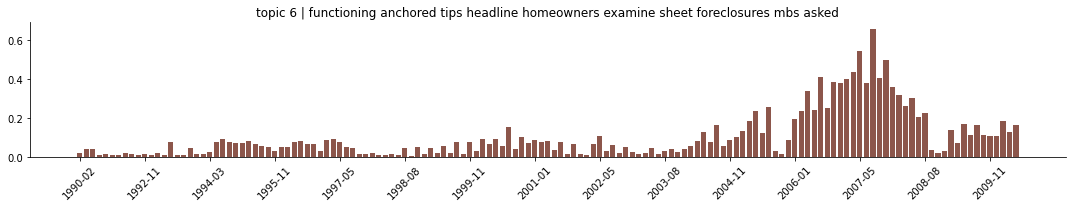

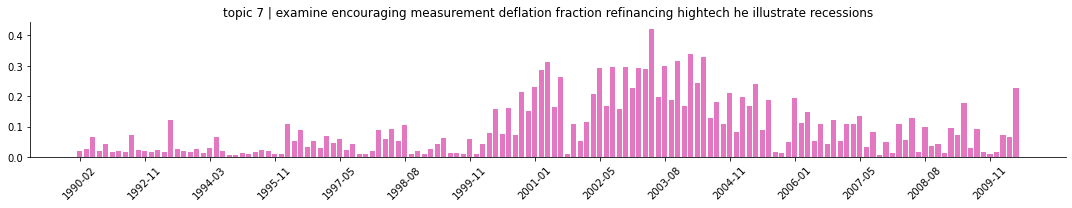

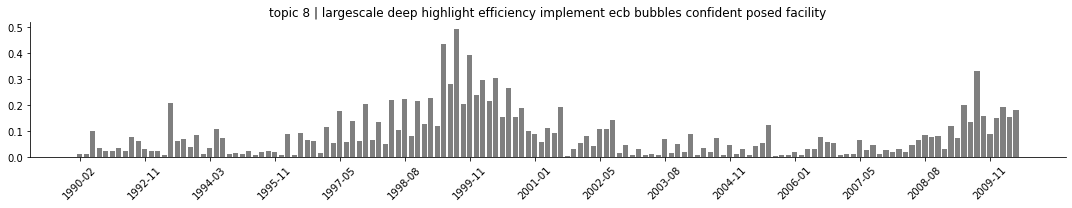

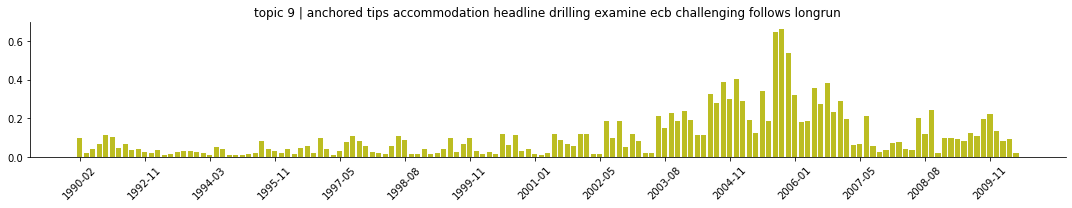

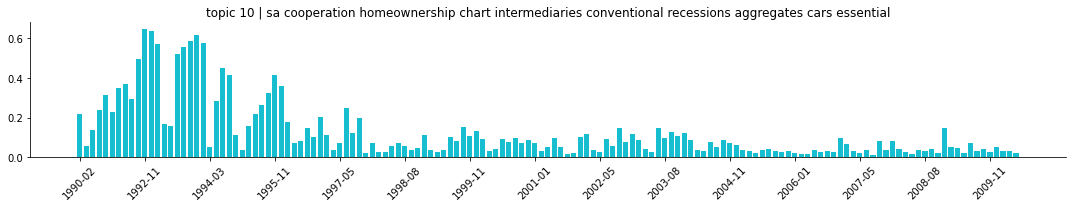

In [562]:
width = 15
height= 3
freq = 10
rotation = 45
for topic,color in zip(theta_gb.columns,sns.color_palette()):
    fig = plt.figure(figsize=(width,height))
    plt.bar(theta_gb.index, theta_gb[topic],width=.8, color = color)
    plt.xticks(theta_gb.index[::freq], rotation=rotation)
    plt.title("topic {} | {}".format(topic +1,topicdata.topwords[topic]))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(model_output,"{}_topic{}_gb_timeseries.pdf".format(target,topic+1)))

# Target gb timeseries 

In [563]:
train_y = pd.read_csv(data_dir + "scholar_alltext_traindev/train.target_{}.csv".format(target), index_col = 0)
test_y = pd.read_csv(data_dir + "scholar_alltext_traindev/dev.target_{}.csv".format(target), index_col = 0)
train_covars = pd.read_csv(data_dir + "scholar_alltext_traindev/train.covars.csv", index_col = 0)
test_covars = pd.read_csv(data_dir + "scholar_alltext_traindev/dev.covars.csv", index_col = 0)

In [564]:
# load y data - actual and predicted
#df_y = pd.read_csv(os.path.join(model_path,"y_actuals.train_best_dev.csv"),index_col = 0)
train_ypred = pd.read_csv(os.path.join(model_path,"y_predictions.train_best_dev.csv"),index_col = 0)
train_res_y = train_y.values - train_ypred.values

In [565]:
# Pure OLS model
model = sm.OLS(train_y.values,train_covars.values)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.458
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                              39.92
Date:                Wed, 12 May 2021   Prob (F-statistic):                    9.03e-19
Time:                        09:52:12   Log-Likelihood:                         -35.794
No. Observations:                 145   AIC:                                      77.59
Df Residuals:                     142   BIC:                                      86.52
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1650      0.020     -8.131      0.000      -0.205      -0.125
x2             0.0099      0.014      0.721      0.472      -0.017       0.037
x3            -0.1268      0.014     -8.851      0.000      -0.155      -0.098
==============================================================================
Omnibus:                        8.969   Durbin-Watson:                   1.130
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               14.890
Skew:                           0.257   Prob(JB):                     0.000584
Kurtosis:                       4.484   Cond. No.                         1.84
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [566]:
train_pred_y_ols = results.predict(train_covars.values)
train_res_y_ols = train_y["0"] - train_pred_y_ols

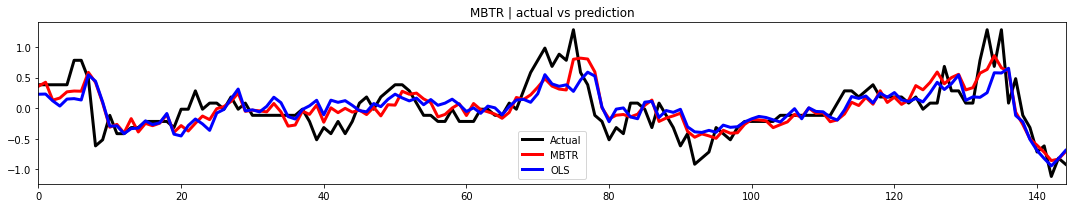

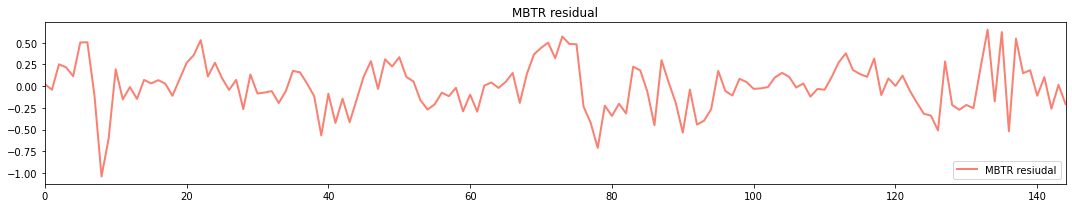

In [567]:
width = 15
height = 3
# plot
names = ["","_res-mbtr"]
for idx  in range(2):
    fig = plt.figure(figsize=(width,height))
    if idx == 0:
        plt.plot(train_y.values, color = "black",linewidth = 3)
        plt.plot(train_ypred.values, color = "red",linewidth = 3)
        plt.plot(train_pred_y_ols, color = "blue",linewidth = 3)
        #plt.xticks(gb_dates)
        plt.legend(["Actual","MBTR","OLS"])
        plt.title("MBTR | actual vs prediction")        
    else:
        #plt.plot(df_y.values, color = "black",linewidth = 3)
        plt.plot(train_res_y, color = "salmon", linestyle = "-", linewidth = 2)
        plt.legend(["MBTR resiudal"])   
        plt.title("MBTR residual")
    plt.margins(x=0)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    #ry:
    plt.savefig(os.path.join(model_output,'gb_{}_yplot{}.pdf').format(target,names[idx]))
    #except:
        #os.mkdir(os.path.join(model_output,"figures"))
    #    plt.savefig(os.path.join(model_path,'{}_yplot{}.pdf').format(target,names[idx]))
    plt.show()

# TIME SERIES SPEECHES

### Delete empty documents in timeseries

In [568]:
keep = pd.read_csv(data_dir + "speeches_dtm+data/delete_empty_speeches.csv", index_col = 0).values

### Load SPEECH thetas

In [569]:
# delete empty docs
gb_dates_sp = pd.DataFrame(gb_dates_sp)[keep]

In [570]:
theta_sp =  pd.DataFrame(np.load(os.path.join(model_path,"theta.test_best_dev.npz"))["theta"])
try:
    theta_sp.index = gb_dates_sp[0].values
except:
    pass

In [571]:
theta_sp

,0,1,2,3,4,5,6,7,8,9
1993-03,0.201089,0.113625,0.101487,0.116581,0.102960,0.036992,0.046361,0.130726,0.052720,0.097460
1995-01,0.170409,0.101603,0.114039,0.102546,0.079704,0.057998,0.066007,0.143010,0.064052,0.100632
1995-12,0.140626,0.093267,0.113384,0.094844,0.096519,0.059475,0.099254,0.129286,0.077390,0.095954
1995-12,0.173171,0.101149,0.129250,0.105733,0.106032,0.042389,0.064608,0.124350,0.058259,0.095058
1996-01,0.169786,0.074889,0.143469,0.112707,0.068695,0.036096,0.095618,0.151579,0.040163,0.106997
...,...,...,...,...,...,...,...,...,...,...
2013-10,0.148573,0.072291,0.110302,0.097129,0.095211,0.050183,0.113002,0.113299,0.094981,0.105029
2013-10,0.145940,0.101604,0.096714,0.083543,0.090426,0.072102,0.111184,0.121237,0.087767,0.089483
2013-10,0.144155,0.103773,0.100054,0.083742,0.093681,0.071858,0.111509,0.117948,0.082287,0.090993
2013-10,0.148500,0.094984,0.097190,0.085729,0.093616,0.064767,0.117186,0.117035,0.084481,0.096512


### Speech topics over time

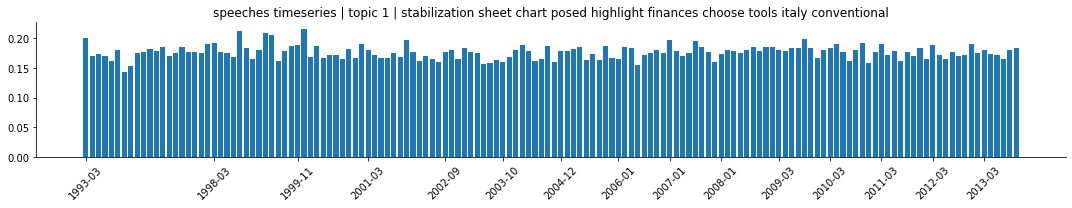

<Figure size 432x288 with 0 Axes>

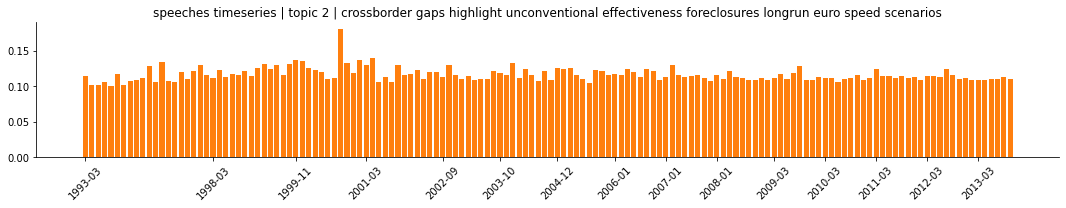

<Figure size 432x288 with 0 Axes>

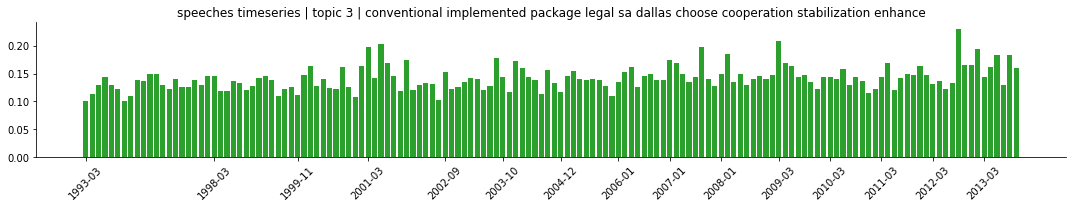

<Figure size 432x288 with 0 Axes>

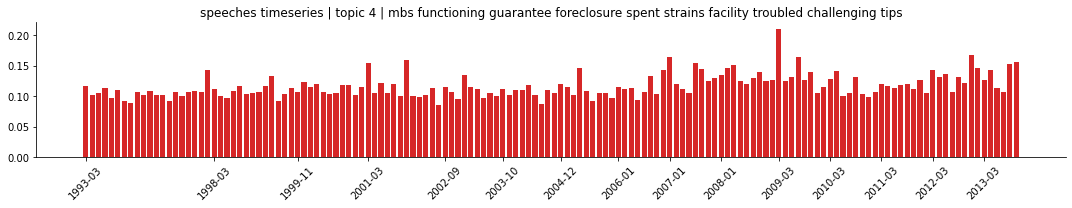

<Figure size 432x288 with 0 Axes>

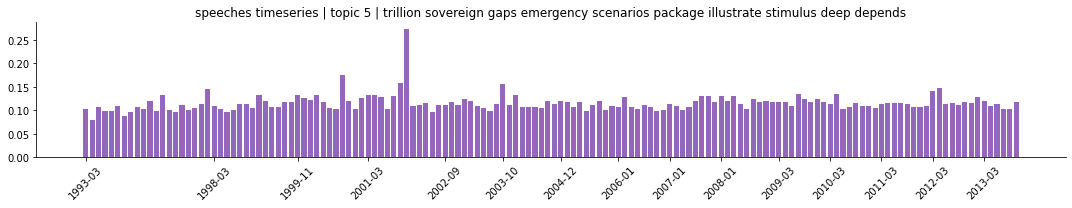

<Figure size 432x288 with 0 Axes>

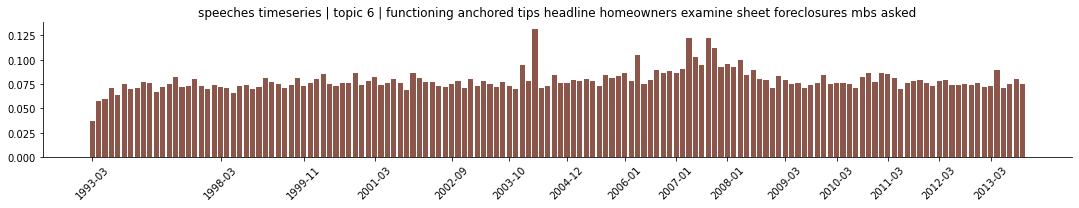

<Figure size 432x288 with 0 Axes>

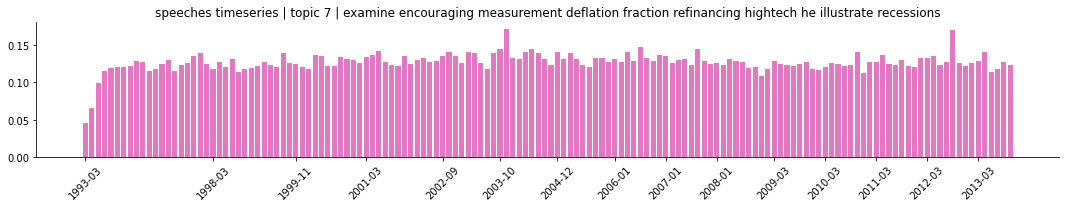

<Figure size 432x288 with 0 Axes>

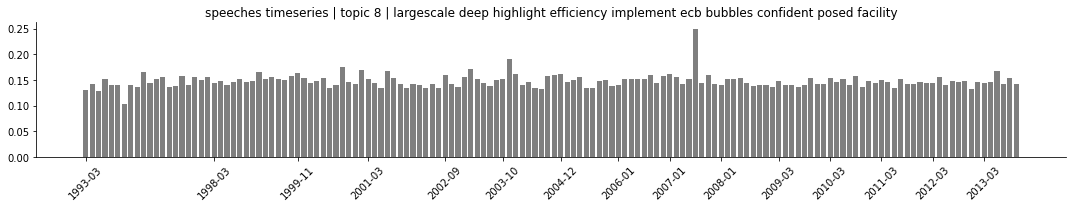

<Figure size 432x288 with 0 Axes>

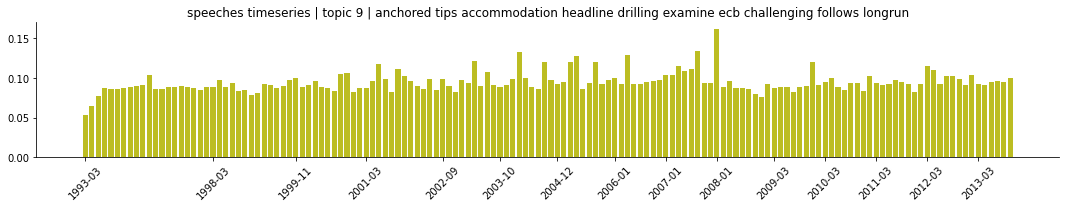

<Figure size 432x288 with 0 Axes>

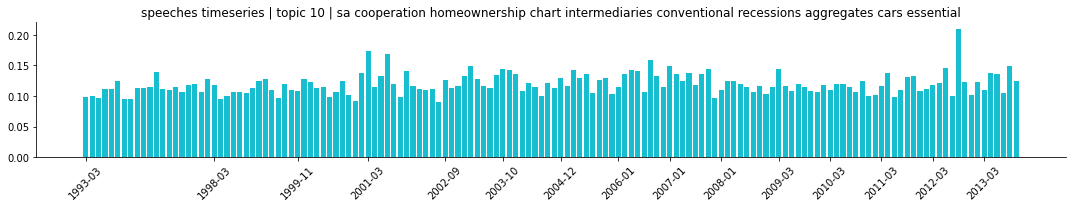

<Figure size 432x288 with 0 Axes>

In [572]:
width = 15
height= 3
freq = 200
rotation = 45
for topic,color in zip(theta_sp.columns,sns.color_palette()):
    fig = plt.figure(figsize=(width,height))
    plt.bar(theta_sp.index, theta_sp[topic],width=.8, color = color)
    plt.xticks(theta_sp.index[::freq], rotation=rotation)
    plt.title("speeches timeseries | topic {} | {}".format(topic +1,topicdata.topwords[topic]))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(model_output,"{}_topic{}_speeches_timeseries.pdf".format(target,topic+1)))

# Target sp timeseries

In [573]:
# load y data - actual and predicted
#df_y = pd.read_csv(os.path.join(model_path,"y_actuals.train_best_dev.csv"),index_col = 0)
test_ypred = pd.read_csv(os.path.join(model_path,"y_predictions.test_best_dev.csv"),index_col = 0)
test_res_y = test_y.values - test_ypred.values

In [574]:
test_pred_y_ols = results.predict(test_covars.values)
test_res_y_ols = test_y["0"] - test_pred_y_ols

test_mse_ols = np.mean((test_res_y_ols)**2)
test_y_var = np.var(test_y)
test_pR_ols = 1- test_mse_ols/test_y_var
print("speeches R2 OLS:",test_pR_ols)

speeches R2 OLS: 0    0.648638
dtype: float64


### Plot residuals for speeches

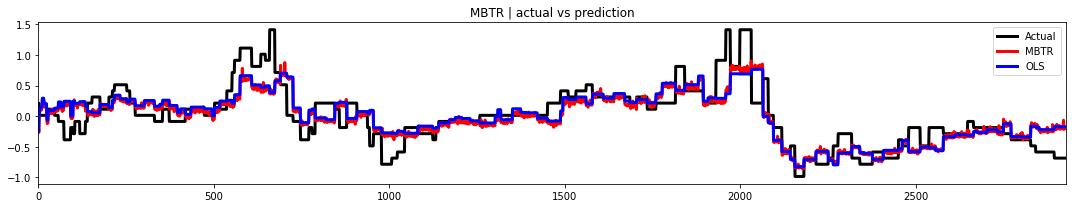

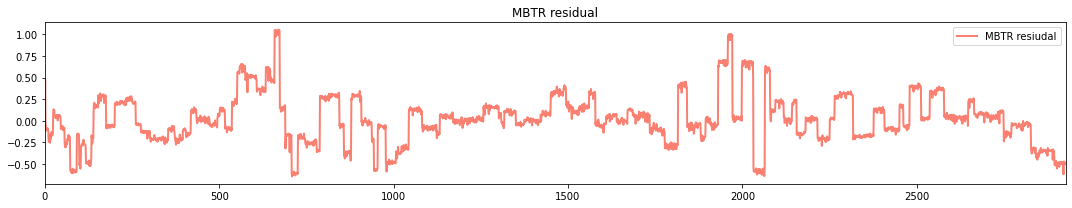

In [575]:
width = 15
height = 3
# plot
names = ["","_res-mbtr"]
for idx  in range(2):
    fig = plt.figure(figsize=(width,height))
    if idx == 0:
        plt.plot(test_y.values, color = "black",linewidth = 3)
        plt.plot(test_ypred.values, color = "red",linewidth = 3)
        plt.plot(test_pred_y_ols, color = "blue",linewidth = 3)
        #plt.xticks(gb_dates)
        plt.legend(["Actual","MBTR","OLS"])
        plt.title("MBTR | actual vs prediction")        
    else:
        #plt.plot(df_y.values, color = "black",linewidth = 3)
        plt.plot(test_res_y, color = "salmon", linestyle = "-", linewidth = 2)
        plt.legend(["MBTR resiudal"])   
        plt.title("MBTR residual")
    plt.margins(x=0)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    #ry:
    plt.savefig(os.path.join(model_output,'speeches_{}_yplot{}.pdf').format(target,names[idx]))
    #except:
        #os.mkdir(os.path.join(model_output,"figures"))
    #    plt.savefig(os.path.join(model_path,'{}_yplot{}.pdf').format(target,names[idx]))
    plt.show()

## Create comprehensive dataset

In [576]:
speeches_metadata = pd.read_csv(data_dir + "speeches_dtm+data/speeches_metadata_tfidf17.csv",index_col=0)
speeches_metadata.reset_index(inplace = True)
speeches_metadata.shape

(2930, 147)

In [577]:
df_speeches = pd.read_pickle(data_dir + "speeches_dtm+data/speeches_database.pkl")
df_speeches.date = df_speeches.date.astype(str)
df_speeches = df_speeches.sort_values("date",ascending = True)
df_speeches.reset_index(drop = True, inplace = True)
df_speeches.head(2)

,date,branch,speaker,text
0,1993-04-02,RIC,broaddus,Thank you very much for that kind introduction...
1,1995-03-16,RIC,broaddus,It is a pleasure and indeed an honor to be wit...


In [578]:
df_speeches= df_speeches[:speeches_metadata.shape[0]]
df_speeches.shape

(2930, 4)

### delete empty documents

In [579]:
speeches_metadata = speeches_metadata[keep]
speeches_metadata.reset_index(drop = True, inplace = True)
speeches_metadata.shape

(2928, 147)

In [580]:
df_speeches = df_speeches[keep]
df_speeches.reset_index(drop = True, inplace = True)
df_speeches.shape

(2928, 4)

In [581]:
theta_sp.reset_index(drop = True, inplace = True)

In [582]:
test_y.columns = ["y_actual"]
test_y.reset_index(drop = True, inplace = True)
test_ypred.columns = ["y_speech_implied"]
theta_sp.columns = ["topic_{}".format(t+1) for t in range(theta_sp.shape[1])]

In [583]:
df_speech_results = pd.concat([test_y, test_ypred, theta_sp],axis = 1) 

In [584]:
df_speech_results = pd.concat([df_speech_results, speeches_metadata],axis = 1)

In [585]:
df_speech_results["text"] = df_speeches[:df_speech_results.shape[0]].text

In [586]:
df_speech_results

,y_actual,y_speech_implied,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,L1rgdp_fe3,L1rgdp_fe4,L1pgdp_fe1,L1pgdp_fe2,L1pgdp_fe3,L1pgdp_fe4,branch,speaker,info_gap,text
0,-0.185929,-0.212095,0.201089,0.113625,0.101487,0.116581,0.102960,0.036992,0.046361,0.130726,...,2.1,0.3,0.4,0.1,0.2,0.2,RIC,broaddus,16,Thank you very much for that kind introduction...
1,0.214071,-0.267470,0.170409,0.101603,0.114039,0.102546,0.079704,0.057998,0.066007,0.143010,...,0.9,0.7,0.2,-0.4,0.2,-0.5,RIC,broaddus,50,It is a pleasure and indeed an honor to be wit...
2,0.014071,0.040737,0.140626,0.093267,0.113384,0.094844,0.096519,0.059475,0.099254,0.129286,...,0.3,-0.4,0.5,-0.1,0.0,0.6,NY,sp,28,I am pleased to be here this morning to addres...
3,0.014071,0.066104,0.173171,0.101149,0.129250,0.105733,0.106032,0.042389,0.064608,0.124350,...,0.3,-0.4,0.5,-0.1,0.0,0.6,NY,sp,42,It is a pleasure to be a part of this private-...
4,0.014071,0.127475,0.169786,0.074889,0.143469,0.112707,0.068695,0.036096,0.095618,0.151579,...,0.4,-0.6,0.4,-0.1,0.1,0.6,KC,hoenig,7,"In recent years, revolutionary changes in..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,-0.685929,-0.177282,0.148573,0.072291,0.110302,0.097129,0.095211,0.050183,0.113002,0.113299,...,NaN,NaN,-0.2,NaN,NaN,NaN,RIC,lacker,41,Good morning. I am honored to speak to the Sub...
2924,-0.685929,-0.204207,0.145940,0.101604,0.096714,0.083543,0.090426,0.072102,0.111184,0.121237,...,NaN,NaN,-0.2,NaN,NaN,NaN,MIN,kocherlakota,41,\nNarayana Kocherlakota \n| President \nFeder...
2925,-0.685929,-0.199387,0.144155,0.103773,0.100054,0.083742,0.093681,0.071858,0.111509,0.117948,...,NaN,NaN,-0.2,NaN,NaN,NaN,ATL,lockhart,43,#threeColLeftColumn { \npadding-top: 5px !impo...
2926,-0.685929,-0.199863,0.148500,0.094984,0.097190,0.085729,0.093616,0.064767,0.117186,0.117035,...,NaN,NaN,-0.2,NaN,NaN,NaN,PHI,plosser,44,Good morning and welcome to the Federal Reserv...


In [587]:
# reorder columns
cols_org = df_speech_results.columns.values
cols_new = ["date",'gb_date',"fomc_date",'branch', 'speaker', "text", 'info_gap','y_actual', 'y_speech_implied', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'yq', 'unemp0', 'unemp1', 'unemp2',
       'unemp3', 'unemp4', 'cpi0', 'cpi1', 'cpi2', 'cpi3', 'cpi4',
       'cpix0', 'cpix1', 'cpix2', 'cpix3', 'cpix4', 'rgdp0', 'rgdp1',
       'rgdp2', 'rgdp3', 'rgdp4', 'pgdp0', 'pgdp1', 'pgdp2', 'pgdp3',
       'pgdp4', 'hq0', 'hq1', 'hq2', 'hq3', 'hq4', 'unemp_updt0',
       'unemp_updt1', 'unemp_updt2', 'unemp_updt3', 'cpi_updt0',
       'cpi_updt1', 'cpi_updt2', 'cpi_updt3', 'cpix_updt0', 'cpix_updt1',
       'cpix_updt2', 'cpix_updt3', 'rgdp_updt0', 'rgdp_updt1',
       'rgdp_updt2', 'rgdp_updt3', 'pgdp_updt0', 'pgdp_updt1',
       'pgdp_updt2', 'pgdp_updt3', 'unemp_fe1', 'unemp_fe2', 'unemp_fe3',
       'unemp_fe4', 'cpi_fe1', 'cpi_fe2', 'cpi_fe3', 'cpi_fe4',
       'cpix_fe1', 'cpix_fe2', 'cpix_fe3', 'cpix_fe4', 'rgdp_fe1',
       'rgdp_fe2', 'rgdp_fe3', 'rgdp_fe4', 'pgdp_fe1', 'pgdp_fe2',
       'pgdp_fe3', 'pgdp_fe4', 'L1unemp0', 'L1unemp1', 'L1unemp2',
       'L1unemp3', 'L1unemp4', 'L1cpi0', 'L1cpi1', 'L1cpi2', 'L1cpi3',
       'L1cpi4', 'L1cpix0', 'L1cpix1', 'L1cpix2', 'L1cpix3', 'L1cpix4',
       'L1rgdp0', 'L1rgdp1', 'L1rgdp2', 'L1rgdp3', 'L1rgdp4', 'L1pgdp0',
       'L1pgdp1', 'L1pgdp2', 'L1pgdp3', 'L1pgdp4', 'L1hq0', 'L1hq1',
       'L1hq2', 'L1hq3', 'L1hq4', 'L1unemp_updt0', 'L1unemp_updt1',
       'L1unemp_updt2', 'L1unemp_updt3', 'L1cpi_updt0', 'L1cpi_updt1',
       'L1cpi_updt2', 'L1cpi_updt3', 'L1cpix_updt0', 'L1cpix_updt1',
       'L1cpix_updt2', 'L1cpix_updt3', 'L1rgdp_updt0', 'L1rgdp_updt1',
       'L1rgdp_updt2', 'L1rgdp_updt3', 'L1pgdp_updt0', 'L1pgdp_updt1',
       'L1pgdp_updt2', 'L1pgdp_updt3', 'L1unemp_fe1', 'L1unemp_fe2',
       'L1unemp_fe3', 'L1unemp_fe4', 'L1cpi_fe1', 'L1cpi_fe2',
       'L1cpi_fe3', 'L1cpi_fe4', 'L1cpix_fe1', 'L1cpix_fe2', 'L1cpix_fe3',
       'L1cpix_fe4', 'L1rgdp_fe1', 'L1rgdp_fe2', 'L1rgdp_fe3',
       'L1rgdp_fe4', 'L1pgdp_fe1', 'L1pgdp_fe2', 'L1pgdp_fe3',
       'L1pgdp_fe4']
df_speech_results = df_speech_results[cols_new]

In [588]:
df_speech_results

,date,gb_date,fomc_date,branch,speaker,text,info_gap,y_actual,y_speech_implied,topic_1,...,L1cpix_fe3,L1cpix_fe4,L1rgdp_fe1,L1rgdp_fe2,L1rgdp_fe3,L1rgdp_fe4,L1pgdp_fe1,L1pgdp_fe2,L1pgdp_fe3,L1pgdp_fe4
0,1993-04-02,1993-03-17,1993-03-23,RIC,broaddus,Thank you very much for that kind introduction...,16,-0.185929,-0.212095,0.201089,...,0.0,0.1,-0.4,-1.7,2.1,0.3,0.4,0.1,0.2,0.2
1,1995-03-16,1995-01-25,1995-02-01,RIC,broaddus,It is a pleasure and indeed an honor to be wit...,50,0.214071,-0.267470,0.170409,...,-0.4,-0.2,-0.5,-2.5,0.9,0.7,0.2,-0.4,0.2,-0.5
2,1996-01-11,1995-12-14,1995-12-19,NY,sp,I am pleased to be here this morning to addres...,28,0.014071,0.040737,0.140626,...,-0.3,-0.3,-1.2,1.1,0.3,-0.4,0.5,-0.1,0.0,0.6
3,1996-01-25,1995-12-14,1995-12-19,NY,sp,It is a pleasure to be a part of this private-...,42,0.014071,0.066104,0.173171,...,-0.3,-0.3,-1.2,1.1,0.3,-0.4,0.5,-0.1,0.0,0.6
4,1996-02-02,1996-01-26,1996-01-31,KC,hoenig,"In recent years, revolutionary changes in...",7,0.014071,0.127475,0.169786,...,-0.3,-0.3,-1.0,1.4,0.4,-0.6,0.4,-0.1,0.1,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2013-12-03,2013-10-23,2013-10-30,RIC,lacker,Good morning. I am honored to speak to the Sub...,41,-0.685929,-0.177282,0.148573,...,NaN,NaN,-1.0,NaN,NaN,NaN,-0.2,NaN,NaN,NaN
2924,2013-12-03,2013-10-23,2013-10-30,MIN,kocherlakota,\nNarayana Kocherlakota \n| President \nFeder...,41,-0.685929,-0.204207,0.145940,...,NaN,NaN,-1.0,NaN,NaN,NaN,-0.2,NaN,NaN,NaN
2925,2013-12-05,2013-10-23,2013-10-30,ATL,lockhart,#threeColLeftColumn { \npadding-top: 5px !impo...,43,-0.685929,-0.199387,0.144155,...,NaN,NaN,-1.0,NaN,NaN,NaN,-0.2,NaN,NaN,NaN
2926,2013-12-06,2013-10-23,2013-10-30,PHI,plosser,Good morning and welcome to the Federal Reserv...,44,-0.685929,-0.199863,0.148500,...,NaN,NaN,-1.0,NaN,NaN,NaN,-0.2,NaN,NaN,NaN


In [589]:
# adjust for misspelled speaker names
speaker_adj = []
for speaker in df_speech_results.speaker:
    if speaker == "Bernanke2":
        speaker_adj.append("Bernanke")
    elif speaker == "Ferguson2":
        speaker_adj.append("Ferguson")
    elif speaker == "Greenspan2" or speaker == "Greenspan3":
        speaker_adj.append("Greenspan")
    elif speaker == "Rivlin2":
        speaker_adj.append("Rivlin")
    else:
        speaker_adj.append(speaker)

In [590]:
df_speech_results["speaker"] = speaker_adj

In [591]:
df_speech_results.to_pickle(data_dir+"/speech_signals_scholar/"+target+"/speeches_"+target+"_signal.pkl")

In [592]:
df_speech_results.to_pickle(data_dir+"/speech_signals_scholar/"+target+"/speeches_"+target+"_signal.xlsx")

## Plot speeches signals

actual_series = df_speech_results[["date","y_actual"]]
actual_series

a = actual_series.merge(data, on = "date", how = "left")
#plt.plot(a.y_actual_x)
plt.plot(a.y_actual_y)

## All speakers

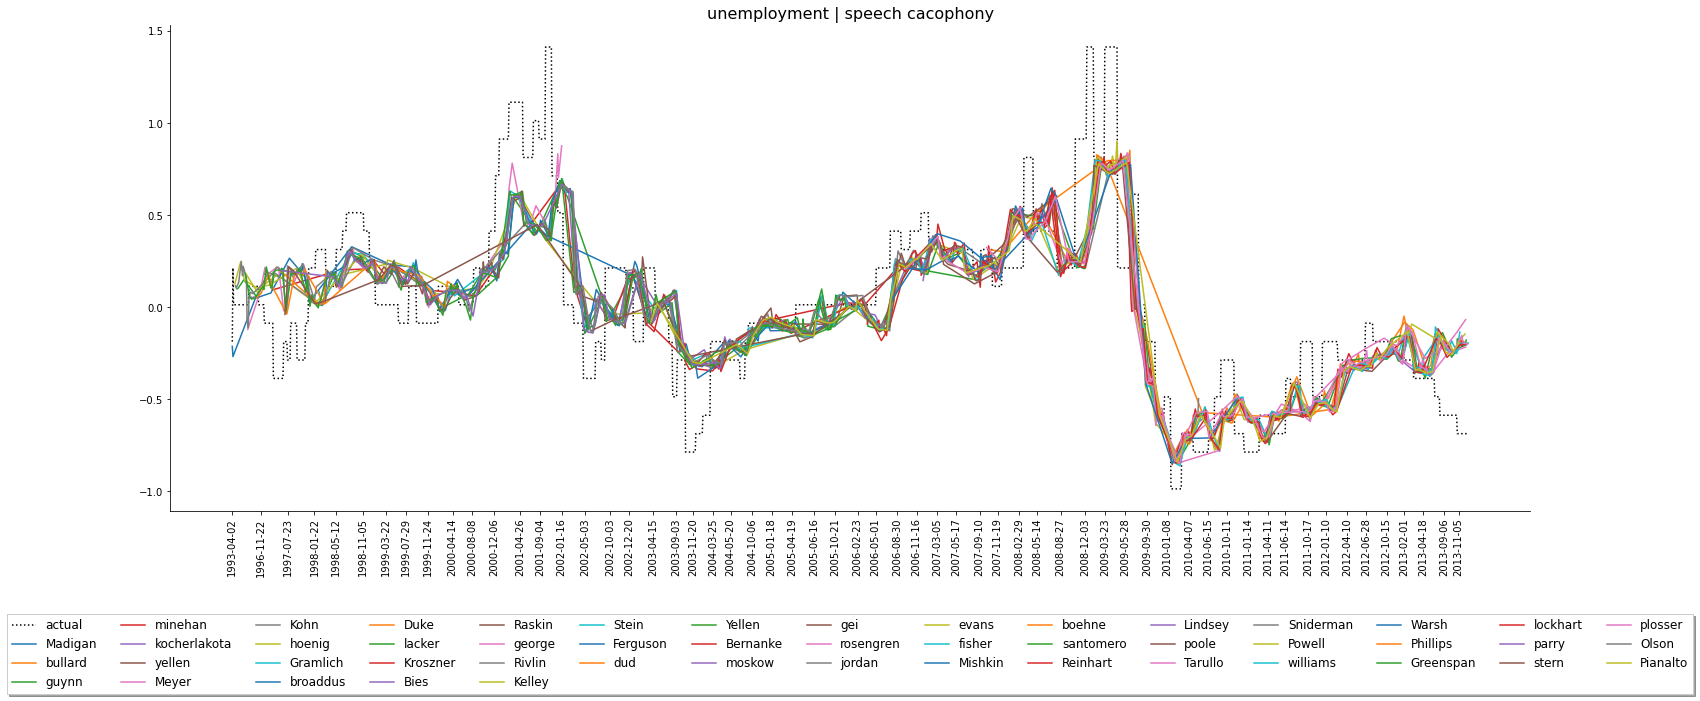

In [594]:
if target =="u":
    name = "unemployment"
else:
    name = target
speakers_list = set(df_speech_results.speaker) - set(["mc","mcd",np.nan,"pdf","sp"]) #all
color_multiplier = int(np.ceil(len(speakers_list)/len(sns.color_palette())))
plt.figure(figsize=(24,10))
plt.plot(df_speech_results.date, df_speech_results.y_actual, label = "actual", color = "black", linestyle = ":")
for speaker ,color in zip(speakers_list,sns.color_palette()*color_multiplier):
    data = df_speech_results[df_speech_results.speaker == speaker]
    plt.plot(data.date, data.y_speech_implied, color = color, label = speaker)
plt.xticks(df_speech_results.date[::50], rotation=90)
plt.title("{} | speech cacophony".format(name), fontsize = 16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=False, shadow=True, ncol=15, fontsize = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(data_dir + "/speech_signals_scholar/"+target+"/figures/"+target+"_speech_cacophony_allspeakers.pdf")
plt.show()

## Selected speakers

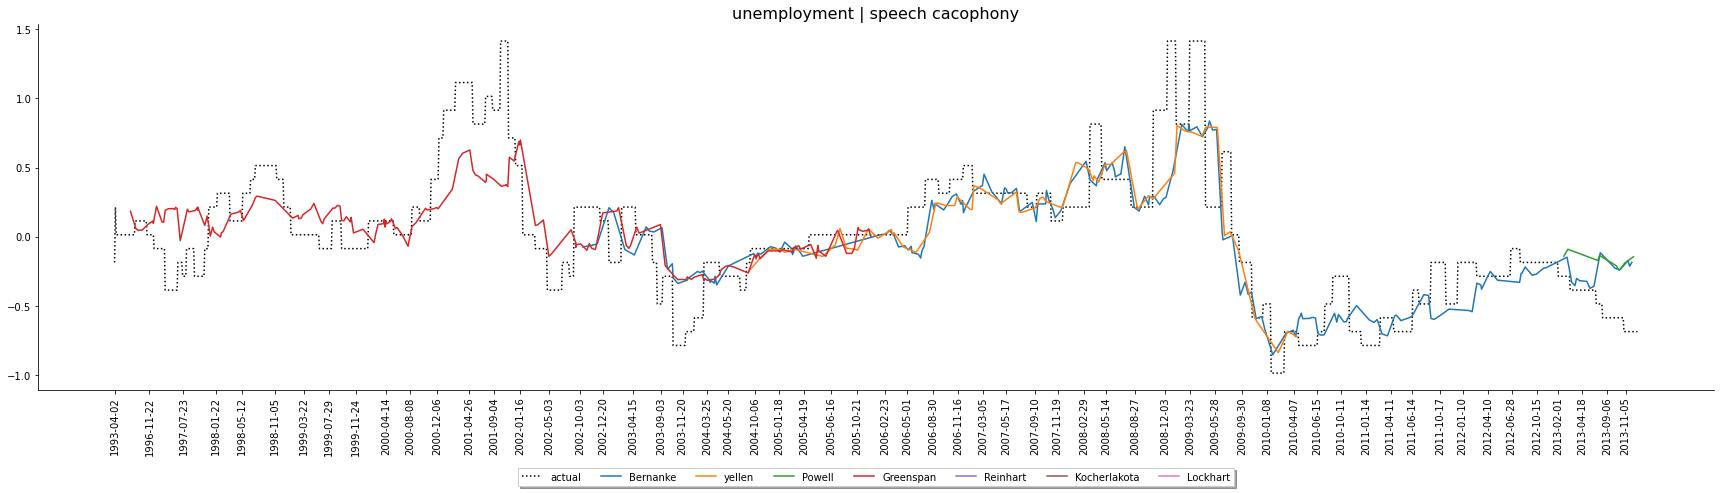

In [595]:
if target =="u":
    name = "unemployment"
else:
    name = target
speakers_list = ["Bernanke","yellen", "Powell","Greenspan","Reinhart","Kocherlakota","Lockhart"]
color_multiplier = int(np.ceil(len(speakers_list)/len(sns.color_palette())))
plt.figure(figsize=(24,7))
plt.plot(df_speech_results.date, df_speech_results.y_actual, label = "actual", color = "black", linestyle = ":")
for speaker ,color in zip(speakers_list,sns.color_palette()*color_multiplier):
    data = df_speech_results[df_speech_results.speaker == speaker]
    plt.plot(data.date, data.y_speech_implied, color = color, label = speaker)
plt.xticks(df_speech_results.date[::50], rotation=90)
plt.title("{} | speech cacophony".format(name), fontsize = 16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=False, shadow=True, ncol=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(data_dir + "/speech_signals_scholar/"+target+"/figures/"+target+"_speech_cacophony_selectedspeakers.pdf")
plt.show()

## Dispersion chart

In [596]:
disp_format = df_speech_results.groupby('gb_date')['y_speech_implied']
disp = df_speech_results.assign(min=disp_format.transform(min), max=disp_format.transform(max))

In [597]:
df_disp = disp.groupby("gb_date")["min","max","y_actual"].first()
df_disp.columns = ["min_signal","max_signal","y_actual"]
df_disp["dispersion"] = df_disp.max_signal - df_disp.min_signal

/nfs/home/maxa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


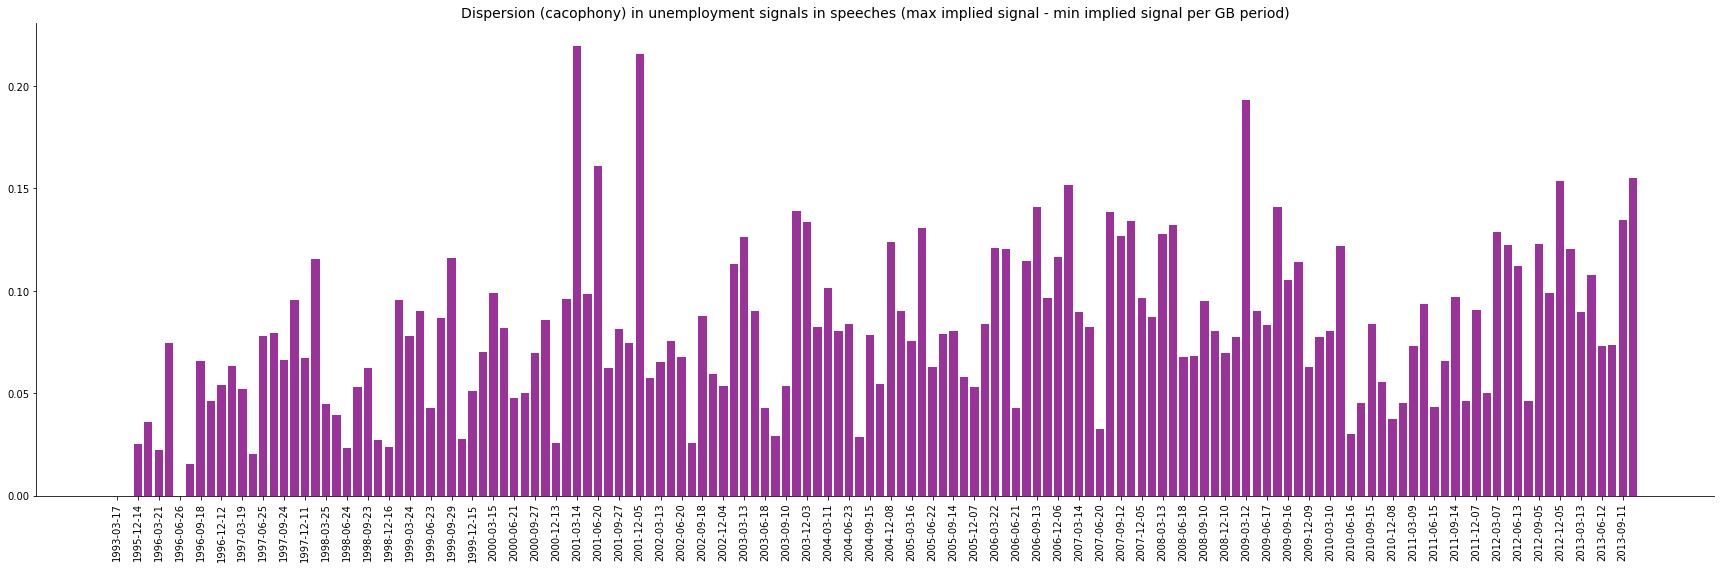

In [598]:
if target == "cpi":
    color = "green"
    alpha = 0.6
    name = target
elif target =="gdp":
    color = "salmon"
    alpha = 1.0
    name = target
elif target =="u":
    color = "purple"
    alpha = 0.8
    name = "unemployment"
plt.figure(figsize=(24,8))
plt.bar(df_disp.index, df_disp.dispersion, color = color,alpha = alpha)
#plt.plot(df_disp.index, df_disp.y_actual, color = "black", linestyle = ":")
plt.xticks(df_disp.index[::2], rotation=90)
plt.title("Dispersion (cacophony) in {} signals in speeches (max implied signal - min implied signal per GB period)".format(name), fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(data_dir + "/speech_signals_scholar/"+target+"/figures/"+target+"_speech_signal_dispersion_barchart.pdf")
plt.show()

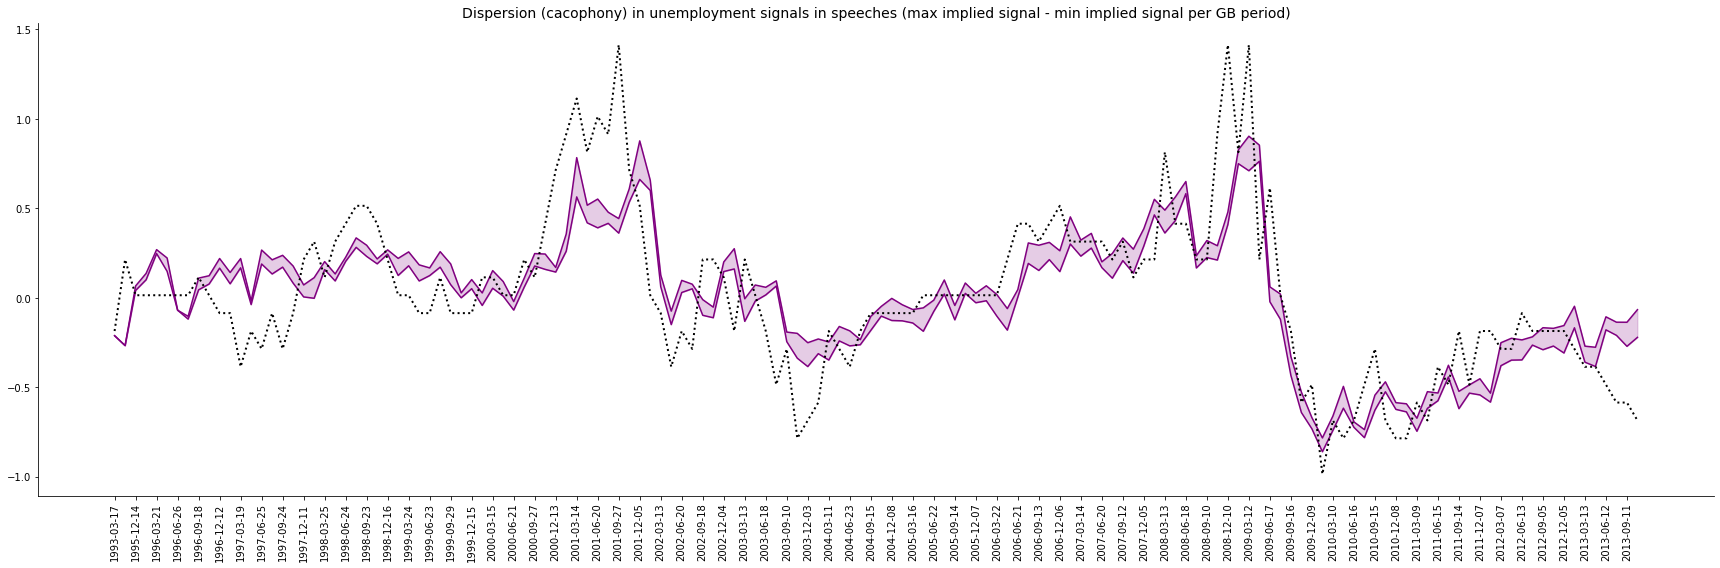

In [599]:
plt.figure(figsize=(24,8))
plt.plot(df_disp.index, df_disp.max_signal, color = color, linewidth = 1.5)
plt.plot(df_disp.index, df_disp.min_signal, color = color, linewidth = 1.5)
plt.fill_between(df_disp.index, df_disp.min_signal,df_disp.max_signal, color = color, alpha = 0.2)
plt.plot(df_disp.index, df_disp.y_actual, color = "black", linestyle = ":",linewidth = 2)
plt.xticks(df_disp.index[::2], rotation=90)
plt.title("Dispersion (cacophony) in {} signals in speeches (max implied signal - min implied signal per GB period)".format(name), fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(data_dir + "/speech_signals_scholar/"+target+"/figures/"+target+"_speech_signal_dispersion.pdf")
plt.show()

## Individual speakers

FileNotFoundError: [Errno 2] No such file or directory: '/Users/maximilianahrens/OneDrive - Nexus365/Michael and Max/Output_speeches/speech_results/speeches_u/indiv_speaker_charts/speech_signal_u_Madigan.pdf'

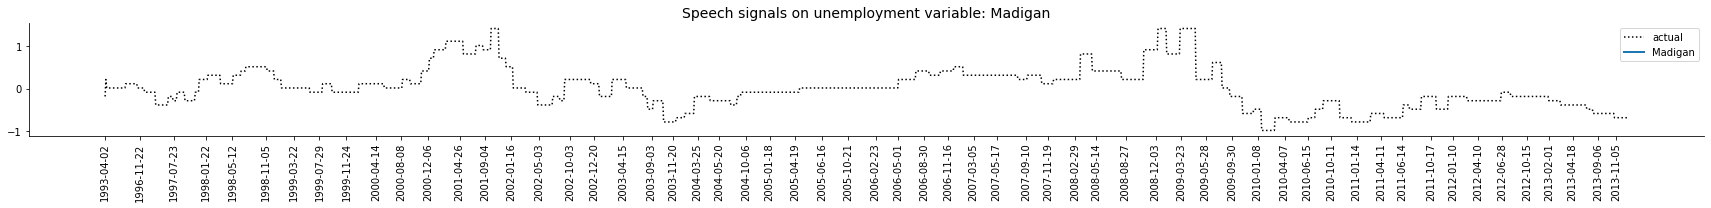

In [600]:
speakers_list = list(set(df_speech_results.speaker) - set(["mc","mcd",np.nan,"pdf","sp"]))
color_multiplier = int(np.ceil(len(speakers_list)/len(sns.color_palette())))
for speaker ,color in zip(speakers_list,sns.color_palette()*color_multiplier):
    plt.figure(figsize=(24,3))
    plt.plot(df_speech_results.date, df_speech_results.y_actual, label = "actual", color = "black", linestyle = ":")
    data = df_speech_results[df_speech_results.speaker == speaker]
    plt.plot(data.date, data.y_speech_implied, color = color, label = speaker, linewidth = 2)
    plt.xticks(df_speech_results.date[::50], rotation=90)
    plt.title("Speech signals on {} variable: {}".format(name, speaker), fontsize = 14)
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(data_dir + "/speech_signals_scholar/"+target+"/figures/indiv_speaker_charts/speech_signal_"+target+"_{}.pdf".format(speaker))
    plt.show()

# 